In [1]:
%config InlineBackend.figure_formats = ['png2x']  # for vector graphics quality, set to svg
import numpy as np
import scanpy.api as sc
sc.settings.verbosity = 3                # show some output
sc.logging.print_version_and_date()

/anaconda/lib/python3.6/site-packages/numba/core/errors.py:144: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Running Scanpy 1.4.3 on 2020-06-05 17:01.


In [2]:
# help(sc.read)

In [3]:
def prepare_rpkmforgenes_for_scanpy(infile, outfile):
    of = open(outfile,'w')
    h = True
    for line in open(infile):
        parts = line.strip().split("\t")
        if h:
            samples = len(parts)-1
            h=False
            of.write(line)
            continue
        else:
            of.write("%s\t%s\n" % (parts[0], "\t".join(parts[2:2+samples])))
    of.close()
    
prepare_rpkmforgenes_for_scanpy('refseq_rpkms.txt',
                                'refseq_rpkms_scanpy.txt')

In [4]:
# read data from any path on your system                                                                                                                                         
adata = sc.read('refseq_rpkms_scanpy.txt')

# other data reading examples
# adata = sc.read(path_to_data + 'myexample.csv')
# adata = sc.read(path_to_data + 'myexample.h5', sheet='countmatrix')
# adata = sc.read(path_to_data + 'myexample.xlsx', sheet='countmatrix')
# adata = sc.read(path_to_data + 'myexample.txt')

# in the data matrix adata.X, rows should correspond to samples and columns to genes                                                                                                             
# to match this convention, transpose your data if necessary                                                                                                                     
adata = adata.transpose()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# prepare meta data from names
cellnames = adata.obs_names
print(cellnames[:3])

Index(['EpRas_2h_11', 'EpRas_2h_14', 'EpRas_2h_13'], dtype='object')


In [6]:
cellline = ['NA' for i in range(721)]
cellstate = ['NA' for i in range(721)]
celllinestate = ['NA' for i in range(721)]
cellinvivo = ['NA' for i in range(721)]

In [7]:
for cidx, cellname in enumerate(cellnames):
    blocks = cellname.split("_")
    if  blocks[1] == 'TGFB':
        blocks[0] = 'EpRas+TGFB'
        blocks[1] = blocks[2]
        
    if blocks[0] in ('EpRas','EpXT','EpRas+TGFB'):
        cellline[cidx] = blocks[0]
    else:
        print(cidx, cellname, blocks, cellline[cidx])
        
    if blocks[1] in ('2h','8d','in'):
        if blocks[1] == 'in':
            cellstate[cidx] = 'invitro'
            cellinvivo[cidx] = 0
        else:
            cellstate[cidx]=blocks[1]
            cellinvivo[cidx] = 1
    else:
        print('2nd', cidx, cellname, blocks)
    
    celllinestate[cidx] = '%s %s' % (cellline[cidx], cellstate[cidx])

In [8]:
print(set(cellline), set(cellstate), set(celllinestate))

{'EpRas', 'EpXT', 'EpRas+TGFB'} {'invitro', '2h', '8d'} {'EpRas+TGFB 8d', 'EpXT 8d', 'EpRas+TGFB invitro', 'EpRas 8d', 'EpXT 2h', 'EpXT invitro', 'EpRas+TGFB 2h', 'EpRas 2h', 'EpRas invitro'}


In [9]:
adata.obs['cellline'] = cellline
adata.obs['cellstate'] = cellstate
adata.obs['invivo'] = cellinvivo
adata.obs['celllinestate'] = celllinestate

In [30]:
# Filter for GFP exp above 5 PRKMs
adata_gfp = adata[:,'eGFP']
adata_gfpp = adata_gfp.X > 1
alldata = adata[adata_gfpp]

/anaconda/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


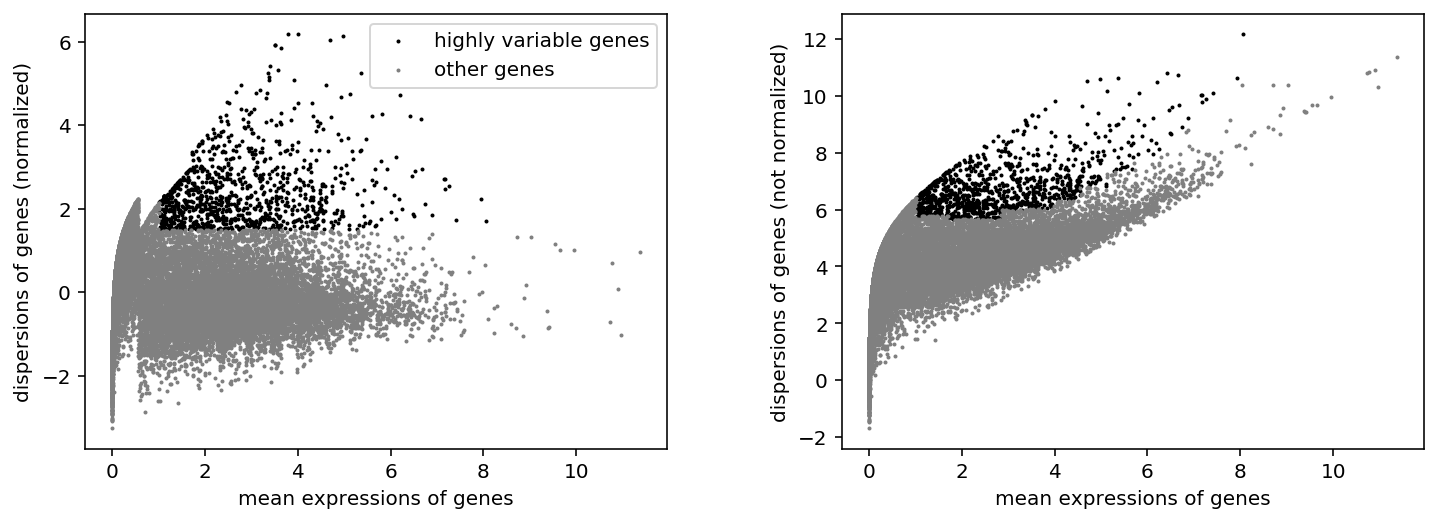

In [11]:
sc.pp.normalize_per_cell(alldata, counts_per_cell_after=1e6)
filter_result = sc.pp.filter_genes_dispersion(
    alldata.X, min_mean=1.0125, max_mean=10, min_disp=1.5)
sc.pl.filter_genes_dispersion(filter_result)

In [12]:
alldata_biolvar = alldata[:, filter_result.gene_subset]
sc.pp.log1p(alldata)
sc.pp.log1p(alldata_biolvar)
print(alldata.X.shape)
print(alldata_biolvar.X.shape)

(346, 24582)
(346, 970)


In [13]:
sc.pp.neighbors(alldata_biolvar)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.07)


/anaconda/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/anaconda/lib/python3.6/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/anaconda/lib/python3.6/site-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-bac

    finished (0:00:05.34) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [14]:
sc.tl.louvain(alldata_biolvar)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.06) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


... storing 'cellline' as categorical
... storing 'cellstate' as categorical
... storing 'celllinestate' as categorical


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.04)


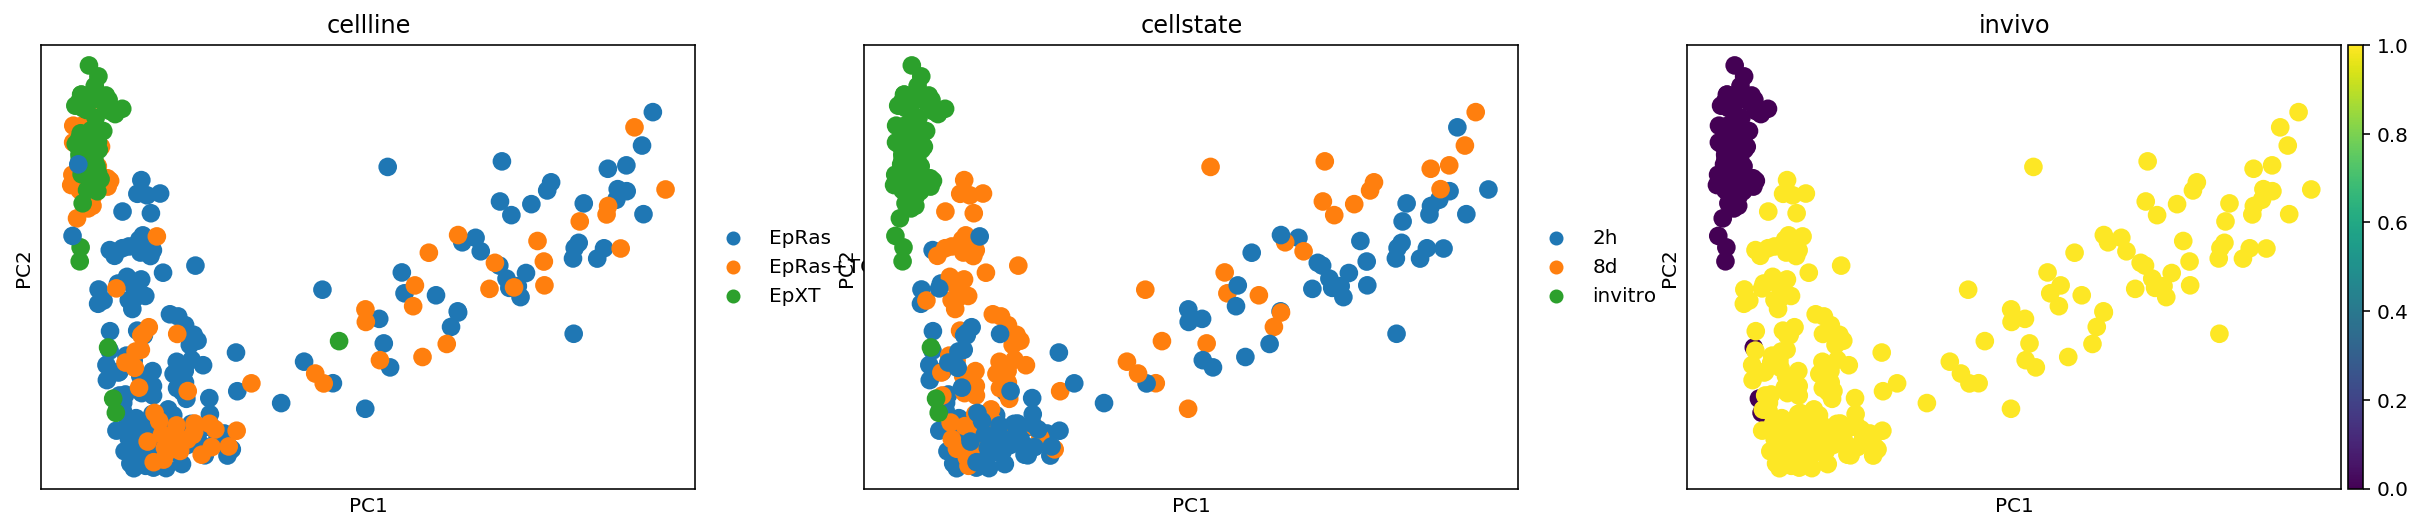

In [15]:
sc.tl.pca(alldata_biolvar)
sc.pl.pca(alldata_biolvar, color=['cellline','cellstate','invivo'])

In [16]:
sc.tl.tsne(alldata_biolvar, n_pcs=10)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:03.00) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


ranking genes
    finished (0:00:00.06) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


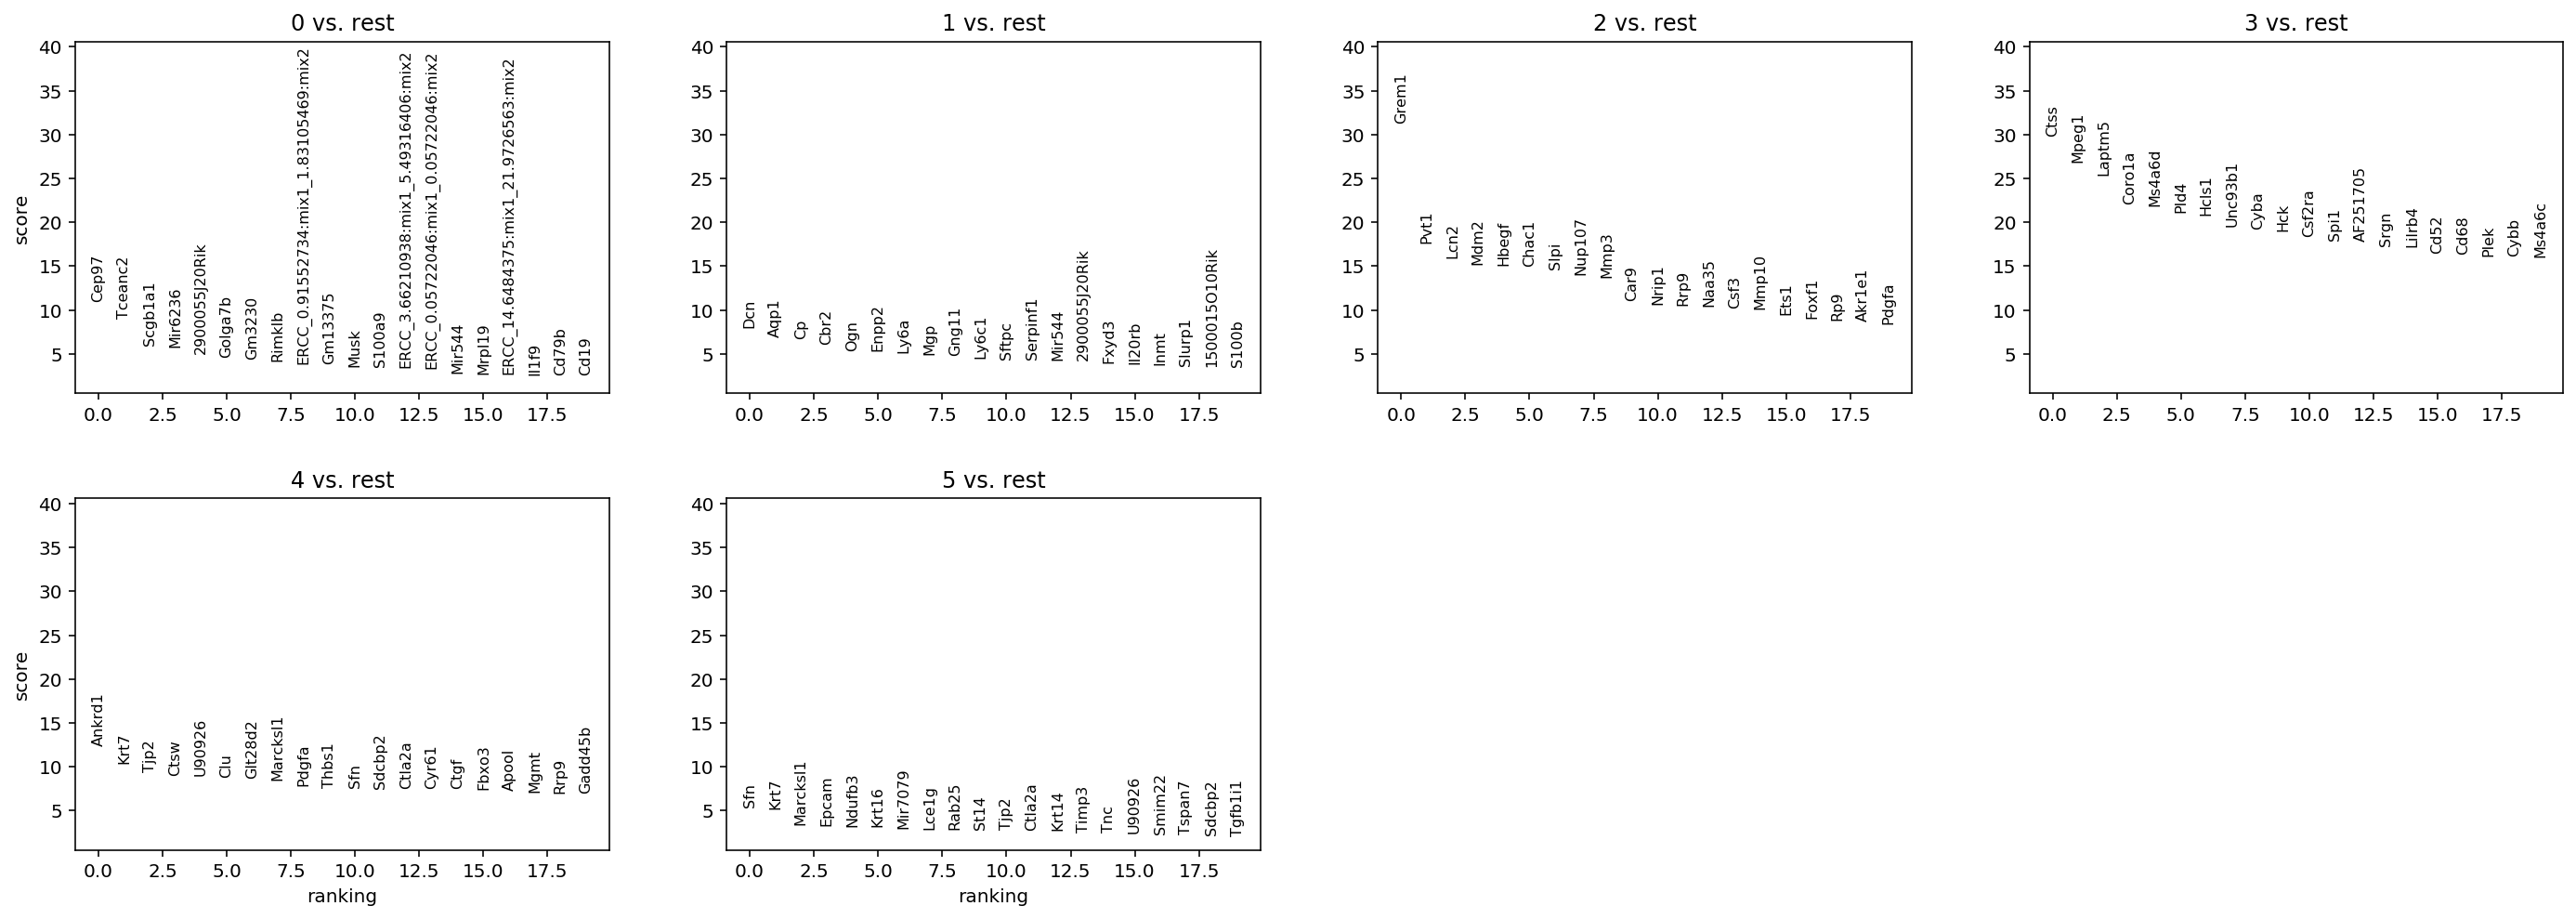

In [17]:
sc.tl.rank_genes_groups(alldata_biolvar, 'louvain')
sc.pl.rank_genes_groups(alldata_biolvar, n_genes=20)

In [18]:
alldata.obsm['X_tsne'] = alldata_biolvar.obsm['X_tsne']

... storing 'cellline' as categorical
... storing 'cellstate' as categorical
... storing 'celllinestate' as categorical
/anaconda/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


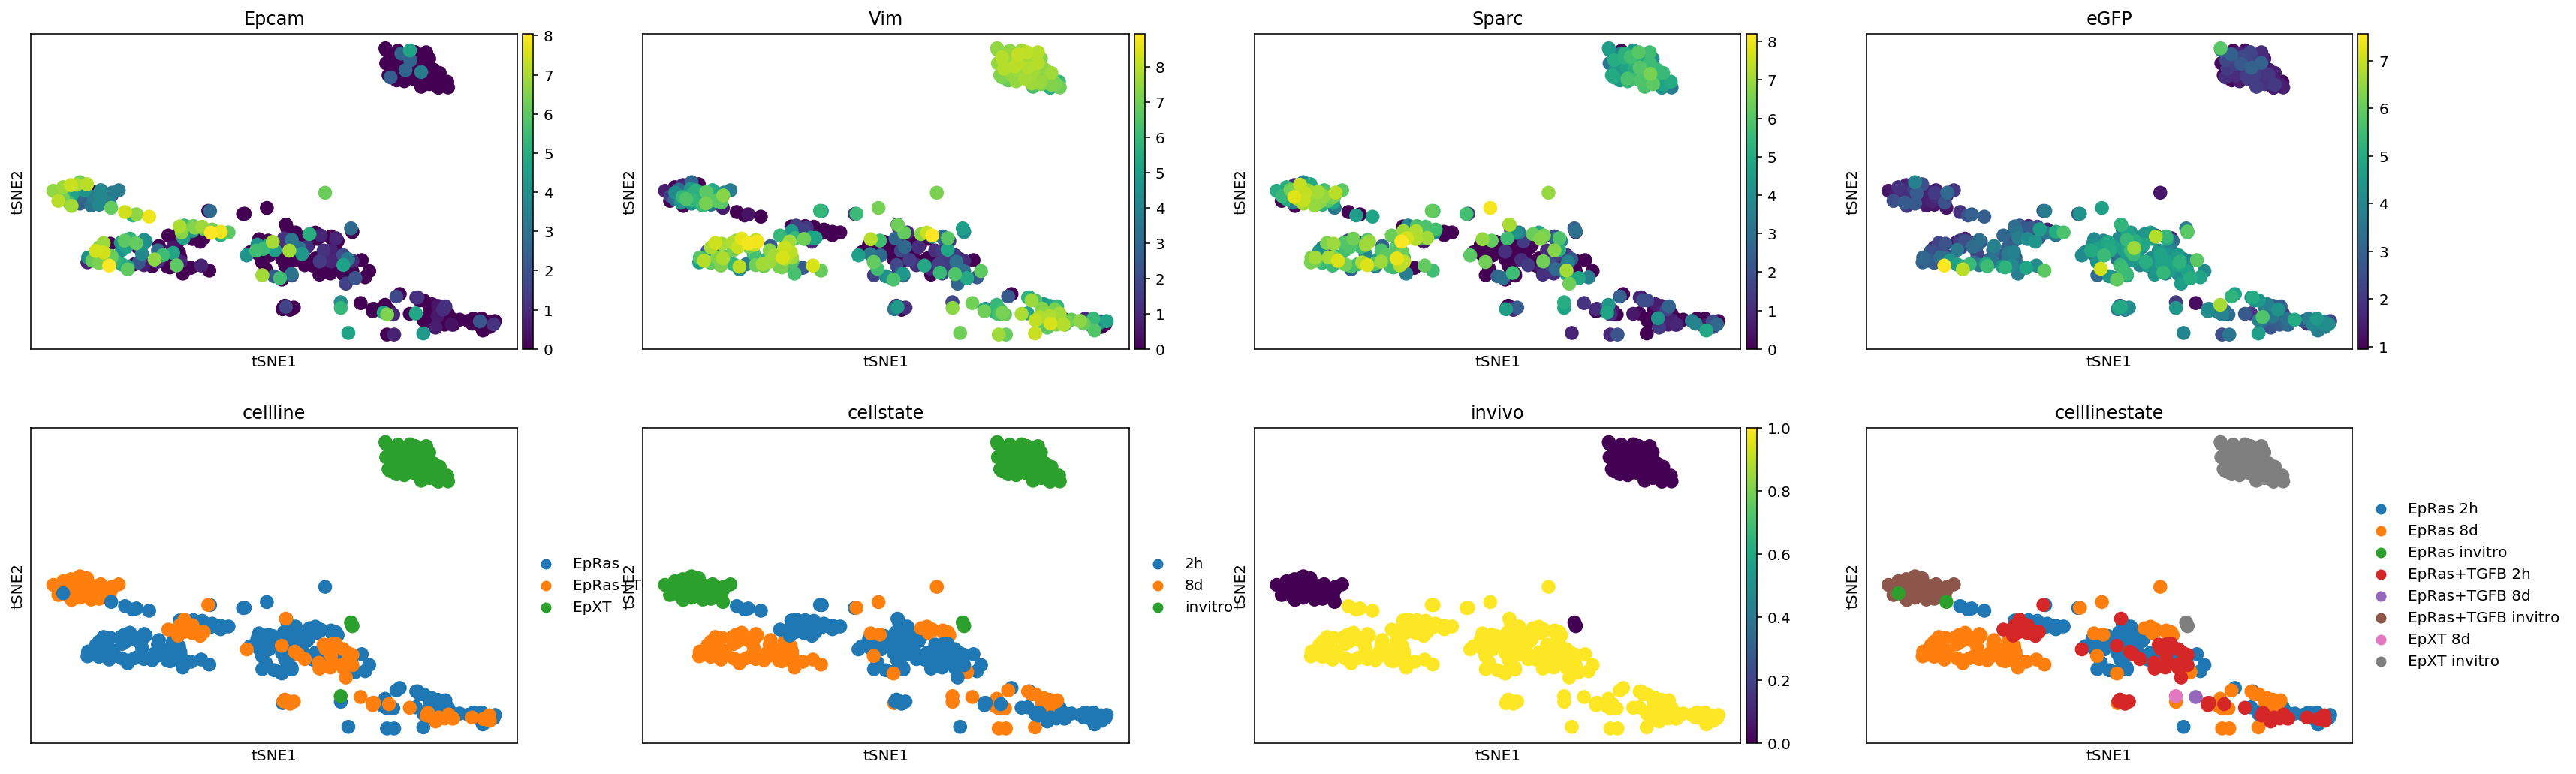

In [19]:
ax = sc.pl.tsne(alldata, color=['Epcam','Vim','Sparc','eGFP','cellline','cellstate','invivo','celllinestate'])

/anaconda/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


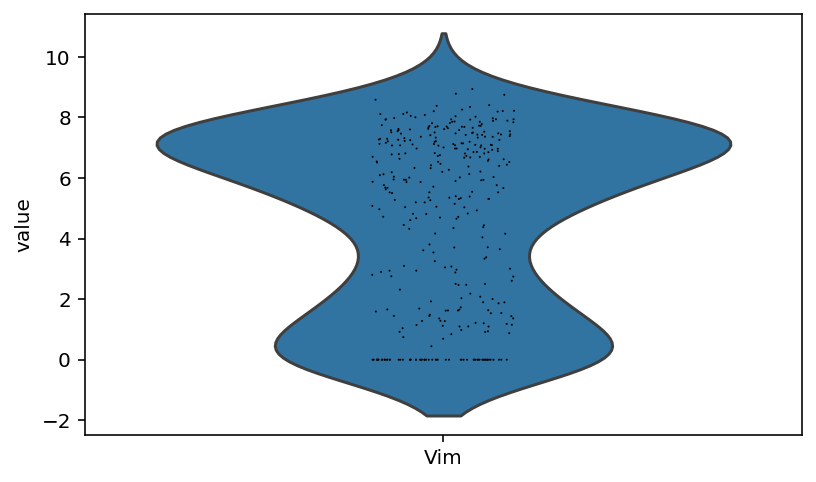

In [20]:
ax = sc.pl.violin(alldata, 'Vim', group_by='celllinestate')

In [21]:
sc.tl.umap(alldata_biolvar)

computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:04.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)


/anaconda/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


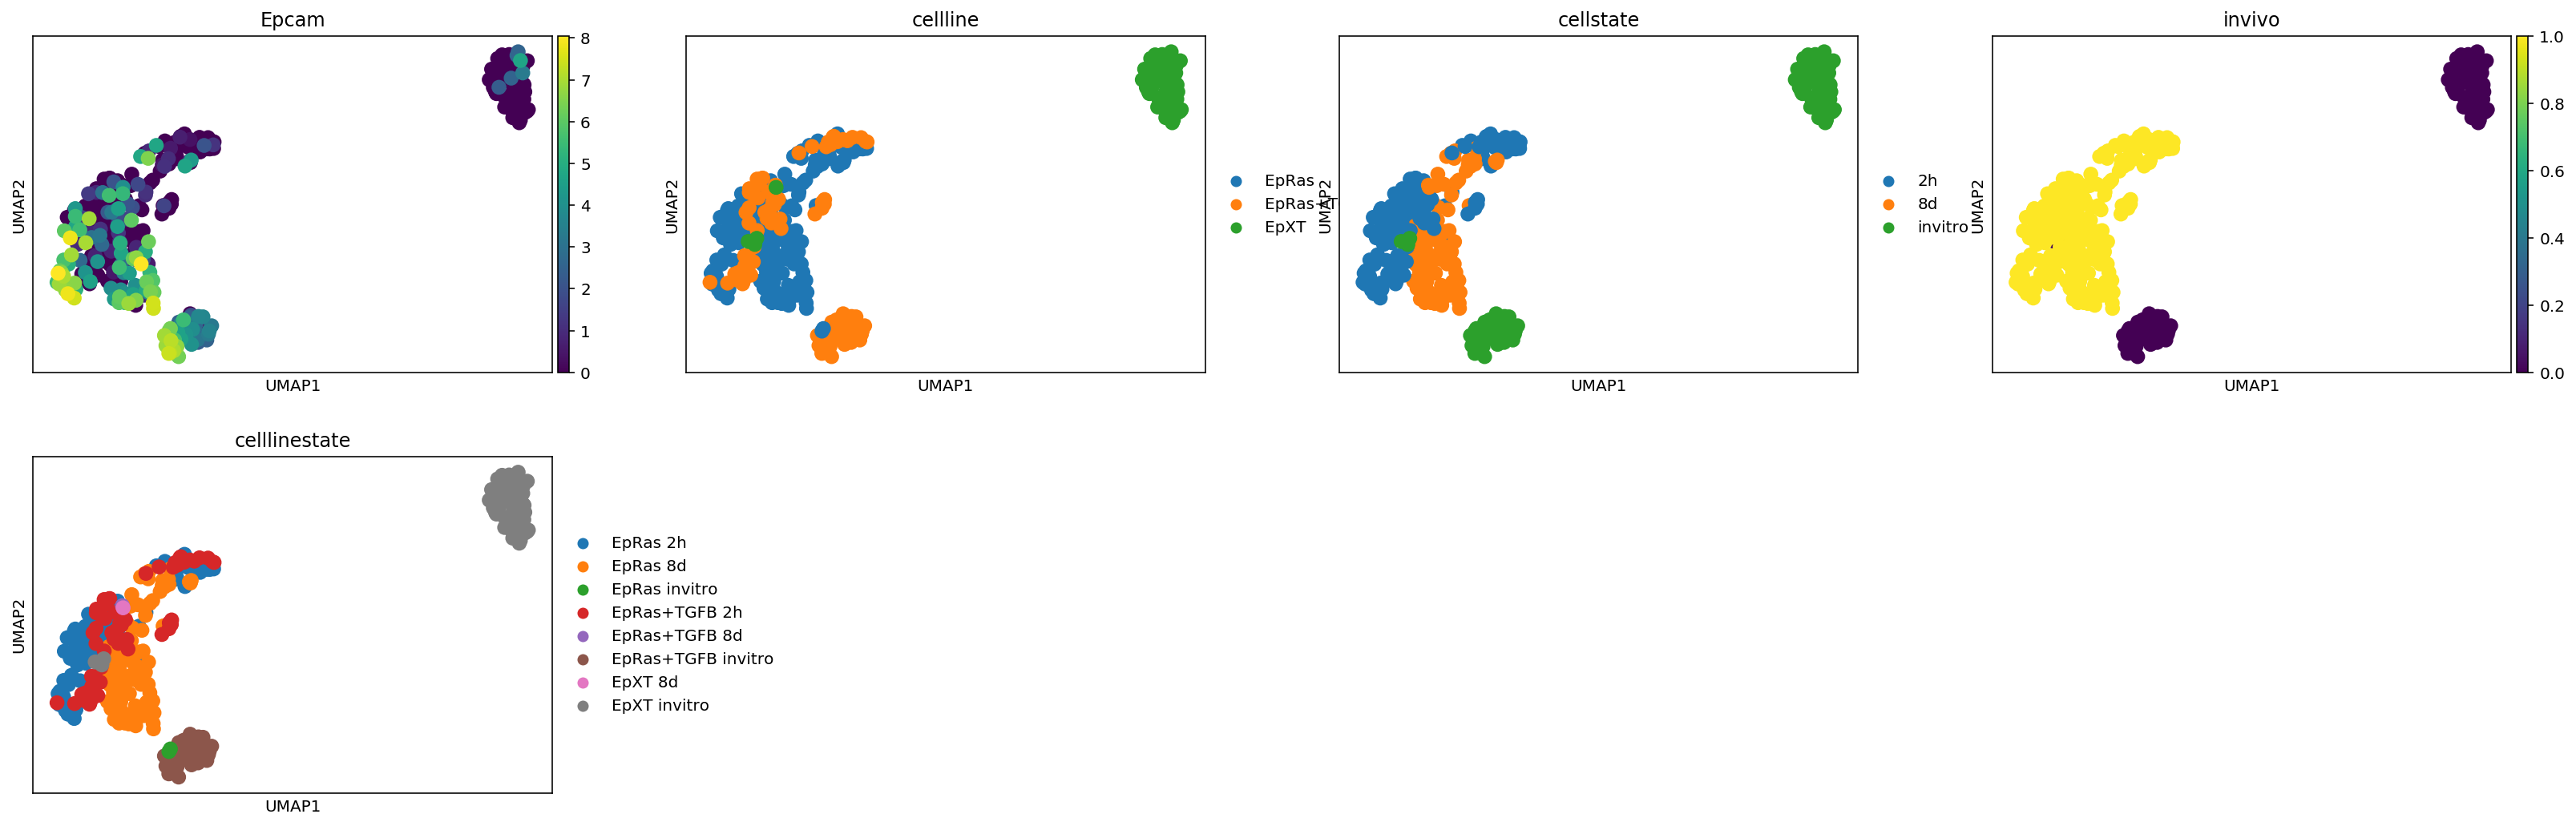

In [22]:
sc.pl.umap(alldata_biolvar, color=['Epcam','cellline','cellstate','invivo','celllinestate'])

# Plot markers across cell lines and samplings stages

In [23]:
marker_genes = ['Epcam','Ecm1','Fn1','Bcl6','Vim','Krt7','Sparc','Cxcl5','Stat1','Il33','Klk10','Mt1','Dcn']

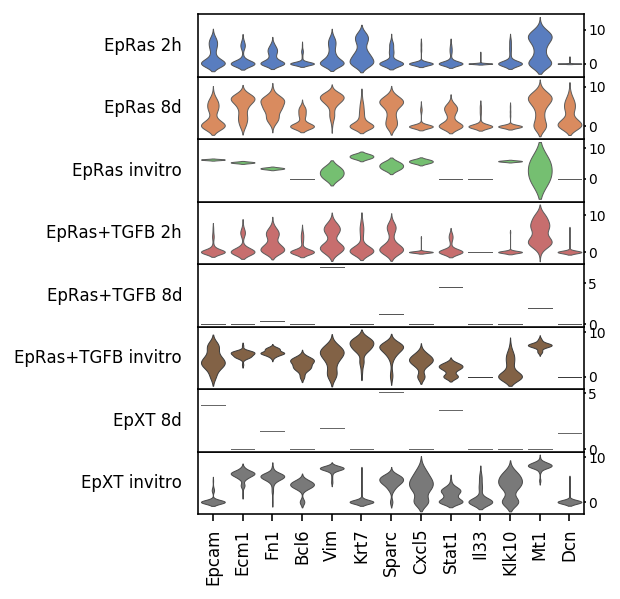

In [24]:
ax = sc.pl.stacked_violin(
    alldata, marker_genes, groupby='celllinestate')

         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.77)
Storing dendrogram info using `.uns['dendrogram_celllinestate']`


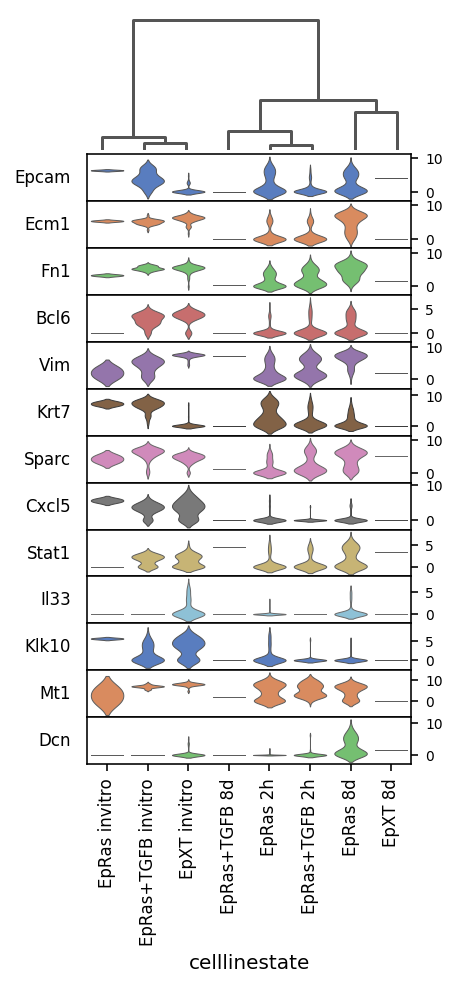

In [25]:
ax = sc.pl.stacked_violin(
    alldata, marker_genes, groupby='celllinestate', swap_axes=True, 
    dendrogram=True)

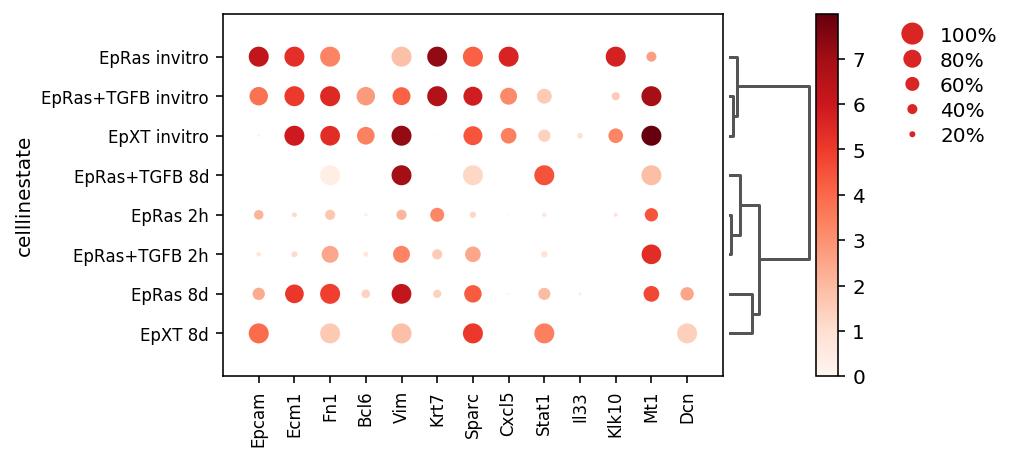

In [26]:
ax = sc.pl.dotplot(alldata, marker_genes, groupby='celllinestate', dendrogram=True)

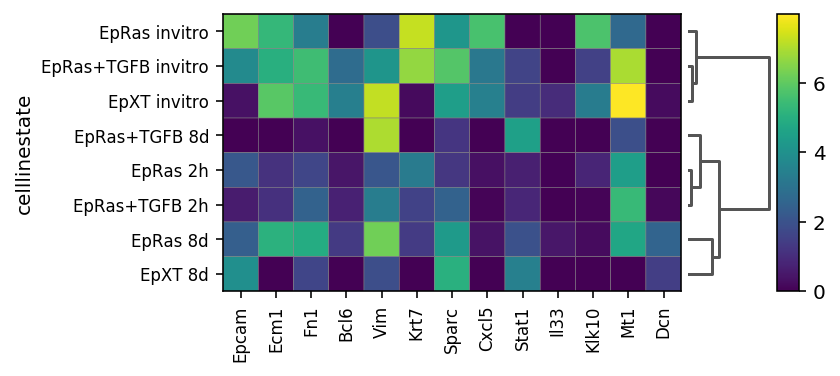

In [27]:
ax = sc.pl.matrixplot(alldata, marker_genes, groupby='celllinestate', dendrogram=True)

In [28]:
sc.tl.rank_genes_groups(alldata, groupby='celllinestate', method='logreg')
#sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5,swap_axes=True)

ranking genes


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:04.21) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids



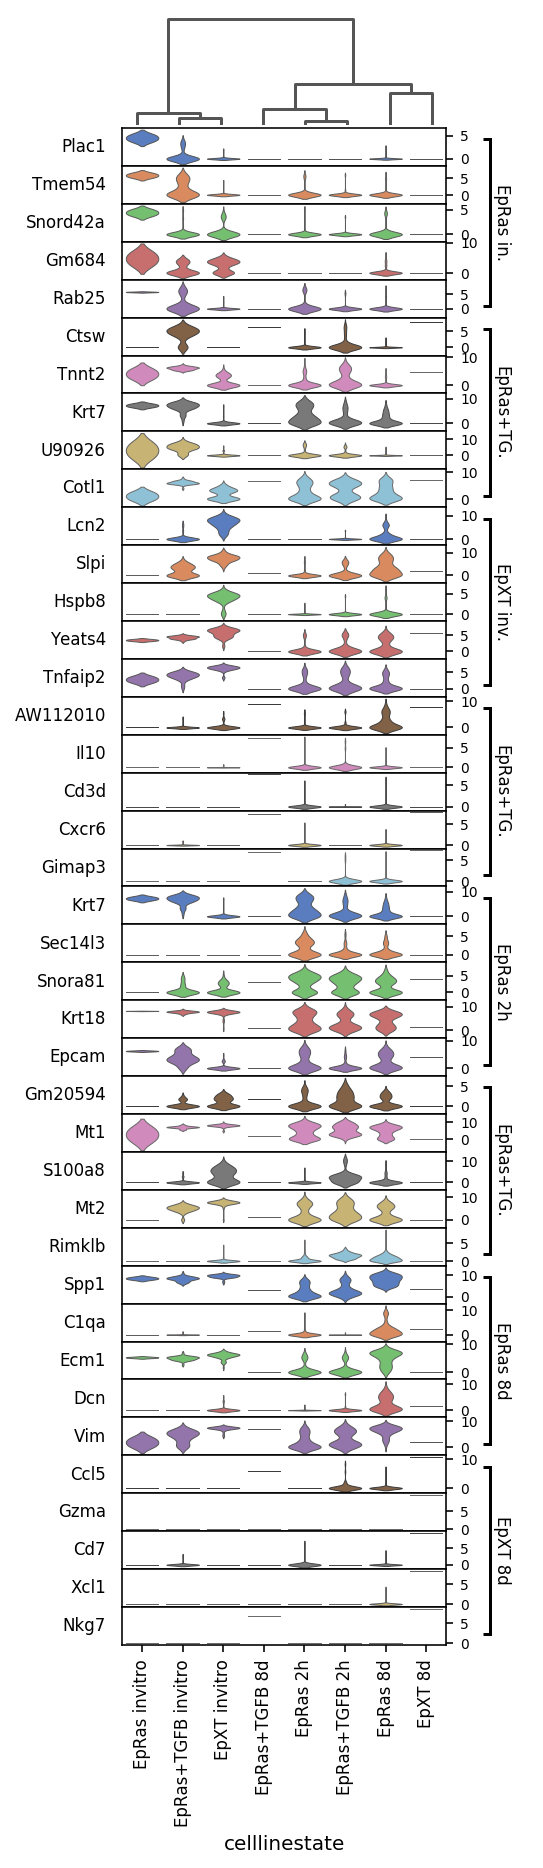

In [29]:
sc.pl.rank_genes_groups_stacked_violin(alldata, n_genes=5,swap_axes=True)